In [16]:
%matplotlib inline

In [17]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

from sklearn import preprocessing

In [18]:
def animatePath(line, point, path, fig):
  
    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point
      
    def animate(i):
        line.set_data(*path[::,:i])
        point.set_data(*path[::,i-1:i])
        return line, point

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=path.shape[1], interval=60, repeat_delay=5, blit=True);
    return anim

In [19]:
def drawPath(myPath, label=""):
    x = list(range(0,len(myPath)))
    y = myPath
    fig, ax = plt.subplots(figsize=(20, 5));
    ax.plot(x, y, '-o', label=label);
    ax.set_xlabel('$x$');
    ax.set_ylabel('$y$');
    ax.set_yscale('log');
    plt.legend()


In [20]:
def makeAnimation(path):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2
    minima = np.array([3., .5])
    minima_ = minima.reshape(-1, 1)
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x, y)

    fig, ax = plt.subplots(figsize=(10, 10));
    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm());
    ax.plot(*minima_, 'r.', markersize=18);
    line, = ax.plot([], [], 'b', label='SGD', lw=2);
    point, = ax.plot([], [], 'bo');
    ax.set_xlabel('$x$');
    ax.set_ylabel('$y$');
    ax.set_xlim((xmin, xmax));
    ax.set_ylim((ymin, ymax));
    ax.legend(loc='upper left');
    
    anim = animatePath(line, point, path, fig);
    return anim
    

In [21]:
def normalizeVector(vector):
    vector = vector.reshape(1, -1)
    vector = preprocessing.normalize(np.array(vector), norm='l2')
    vector = vector[0]
    return vector

In [22]:
def gradientDescent(startX, startY, alpha, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    currentMinimum = np.array([startX, startY])
    path = [currentMinimum]
    alphaPath = [alpha]
    
    for x in range(0, n):
        g = np.array([f_gradx(*currentMinimum), f_grady(*currentMinimum)])
        u = -1.0 * alpha * g
        currentMinimum = currentMinimum + u
        path.append(currentMinimum)
        alphaPath.append(alpha)
        
    print("gradientDescent: ", path[-1])
    
    return np.array(path).T, alphaPath

In [23]:
def gradientDescentNormalized(startX, startY, alpha, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    currentMinimum = np.array([startX, startY])
    path = [currentMinimum]
    alphaPath = [alpha]
    
    for x in range(0, n):
        g = np.array([f_gradx(*currentMinimum), f_grady(*currentMinimum)])
        g = g.reshape(1, -1)
        g = preprocessing.normalize(np.array(g), norm='l2')
        g = g[0]
        u = -1.0 * alpha * g
        currentMinimum = currentMinimum + u
        path.append(currentMinimum)
        alphaPath.append(alpha)
        
    print("gradientDescentNormalized: ", path[-1])
    
    return np.array(path).T, alphaPath

In [24]:
def hypGradientDescent(startX, startY, alpha0, beta, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    currentMinimum = np.array([startX, startY])
    path = [currentMinimum]
    alphaPath = [alpha0]
    
    a_prev = alpha0
    g_prev = np.array([0, 0])
    
    for x in range(0, n):
        g_cur = np.array([f_gradx(*currentMinimum), f_grady(*currentMinimum)])
        h_cur = np.dot(g_cur, -1 * g_prev)
        a_cur = a_prev - beta * h_cur
        u_cur = -1 * a_cur * g_cur
        currentMinimum = currentMinimum + u_cur
        
        path.append(currentMinimum)
        alphaPath.append(a_cur)
        
        """
        print("g_cur", g_cur)
        print("h_cur", h_cur)
        print("a_cur", a_cur)
        print("u_cur", u_cur)
        """
        
        g_prev = g_cur
        a_prev = a_cur
        
    print("hypGradientDescent: ", path[-1])
    
    return np.array(path).T, alphaPath

In [25]:
# TODO: is the normalization right? I don't think so.. I should normalize before alpha and beta...

def hypGradientDescentNormalized(startX, startY, alpha0, beta, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    currentMinimum = np.array([startX, startY])
    path = [currentMinimum]
    alphaPath = [alpha0]
    
    a_prev = alpha0
    g_prev = np.array([0, 0])
    
    for x in range(0, n):
        g_cur = np.array([f_gradx(*currentMinimum), f_grady(*currentMinimum)])
        h_cur = normalizeVector(np.dot(g_cur, -1 * g_prev))
        a_cur = a_prev - beta * h_cur # update rule for alpha
        u_cur = -1 * a_cur * normalizeVector(g_cur) # part of update rule of theta
        currentMinimum = currentMinimum + u_cur
        
        path.append(currentMinimum)
        alphaPath.append(a_cur)
        
        """
        print("g_cur", g_cur)
        print("h_cur", h_cur)
        print("a_cur", a_cur)
        print("u_cur", u_cur)
        """
        
        g_prev = g_cur
        a_prev = a_cur
        
    print("hypGradientDescentNormalized: ", path[-1])
    
    return np.array(path).T, alphaPath

In [26]:
def hypHypGradientDescentNormalized(startX, startY, alpha0, beta0, gamma, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    theta_t = np.array([startX, startY]) # \theta
    
    g_t_0 = np.array([0, 0])
    g_t_1 = np.array([0, 0])
    g_t_2 = np.array([0, 0])
    alpha_t = alpha0
    beta_t = beta0
    
    path_theta = [theta_t]
    path_alpha = [alpha0]
    path_beta = [beta0]
    
    for x in range(0, n):
        g_t_0 = normalizeVector(np.array([f_gradx(*theta_t), f_grady(*theta_t)]))
        
        # TODO: rethink about normaliziation
        
        # update rule for beta
        update_beta = gamma * normalizeVector(np.dot(g_t_0, g_t_1) * np.dot(g_t_1, g_t_2))
        beta_t = beta_t + update_beta
        
        # update rule for alpha
        update_alpha = beta_t * normalizeVector(np.dot(g_t_0, g_t_1))
        alpha_t = alpha_t + update_alpha
        
        # "classical" update rule        
        update_theta = -1 * alpha_t * normalizeVector(g_t_0)
        theta_t = theta_t + update_theta
        
        # save paths
        path_theta.append(theta_t)
        path_alpha.append(alpha_t)
        path_beta.append(beta_t)
        
        # TODO print...
        
        # reassign gradients ...
        g_t_2 = g_t_1
        g_t_1 = g_t_0
        
    print("hypHypGradientDescentNormalized: ", path_theta[-1])
    
    return np.array(path_theta).T, path_alpha, path_beta

In [27]:
def hypHypHypGradientDescentNormalized(startX, startY, alpha0, beta0, gamma0, delta, n = 1000):
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    f_gradx = lambda x, y: -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3 - 2*y - y**2 - 2*y**3 + y**4 + y**6)
    f_grady = lambda x, y: 6*x*(0.5 + 1.5*y + 2.625*y**2 + x*(-0.333333 - 0.333333*y - y**2 + 0.666667*y**3 + y**5))
    
    theta_t = np.array([startX, startY]) # \theta
    
    g_t_0 = np.array([0, 0])
    g_t_1 = np.array([0, 0])
    g_t_2 = np.array([0, 0])
    g_t_3 = np.array([0, 0])
    alpha_t = alpha0
    beta_t = beta0
    gamma_t = gamma0
    
    path_theta = [theta_t]
    path_alpha = [alpha0]
    path_beta = [beta0]
    path_gamma = [gamma0]
    
    for x in range(0, n):
        g_t_0 = normalizeVector(np.array([f_gradx(*theta_t), f_grady(*theta_t)]))
        
        # todo: is the sign right?
        
        # update rule for gamma
        update_gamma = delta * normalizeVector(np.dot(g_t_0, g_t_1) * np.dot(g_t_1, g_t_2) * np.dot(g_t_1, g_t_2) * np.dot(g_t_2, g_t_3))
        gamma_t = gamma_t + update_gamma
        
        # update rule for beta
        update_beta = gamma_t * normalizeVector(np.dot(g_t_0, g_t_1) * np.dot(g_t_1, g_t_2))
        beta_t = beta_t + update_beta
        
        # update rule for alpha
        update_alpha = beta_t * normalizeVector(np.dot(g_t_0, g_t_1))
        alpha_t = alpha_t + update_alpha
        
        # "classical" update rule        
        update_theta = -1 * alpha_t * normalizeVector(g_t_0)
        theta_t = theta_t + update_theta
        
        # save paths
        path_theta.append(theta_t)
        path_alpha.append(alpha_t)
        path_beta.append(beta_t)
        path_gamma.append(gamma_t)
        
        # TODO print...
        
        # reassign gradients ...
        g_t_3 = g_t_2
        g_t_2 = g_t_1
        g_t_1 = g_t_0
        
    print("hypHypHypGradientDescentNormalized: ", path_theta[-1])
    
    return np.array(path_theta).T, path_alpha, path_beta, path_gamma

In [28]:
def drawDistanceToPoint(paths, point):
    
    fig, ax = plt.subplots(figsize=(20, 5));
    
    for pathNr, path in enumerate(paths):
        x = list(range(0,len(path[0])))
        points = np.repeat([point], len(path[0]), axis=0).T
        dist = np.subtract(path, points)
        y = np.linalg.norm(dist.T, axis=1)
        y = y.T
        ax.plot(x, y, '-o', label=pathNr);
    
    ax.set_xlabel('$x$');
    ax.set_ylabel('$y$');
    ax.set_yscale('log');
    plt.legend()

In [29]:
startX = 2
startY = -3
nIterations = 500

print("Minimum: [3, 5]")
# gd_path, gd_alphaPath = gradientDescent(startX, startY, 1e-4, n=nIterations)
# hgd_path, hgd_alphaPath = hypGradientDescent(startX, startY, 1e-9, 1e-9, n=nIterations)

gdn_path, gdn_alphaPath = gradientDescentNormalized(startX, startY, 5e-3, n=nIterations)
hgdn_path, hgdn_alphaPath = hypGradientDescentNormalized(startX, startY, 1e-7, 1e-5, n=nIterations)
hhgdn_path, hhgdn_alphaPath, hhgdn_betaPath = hypHypGradientDescentNormalized(startX, startY, 1e-7, 1e-7, 1e-5, n=nIterations)
hhhgdn_path, hhhgdn_alphaPath, hhhgdn_betaPath, hhhgdn_gammaPath = hypHypHypGradientDescentNormalized(startX, startY, 1e-7, 1e-7, 1e-7, 1e-6, n=nIterations)

Minimum: [3, 5]
gradientDescentNormalized:  [ 1.10688562 -0.77682093]
hypGradientDescentNormalized:  [ 1.41088926 -1.90030754]
hypHypGradientDescentNormalized:  [3.0001837  0.49916373]
hypHypHypGradientDescentNormalized:  [2.99979142 0.49989847]


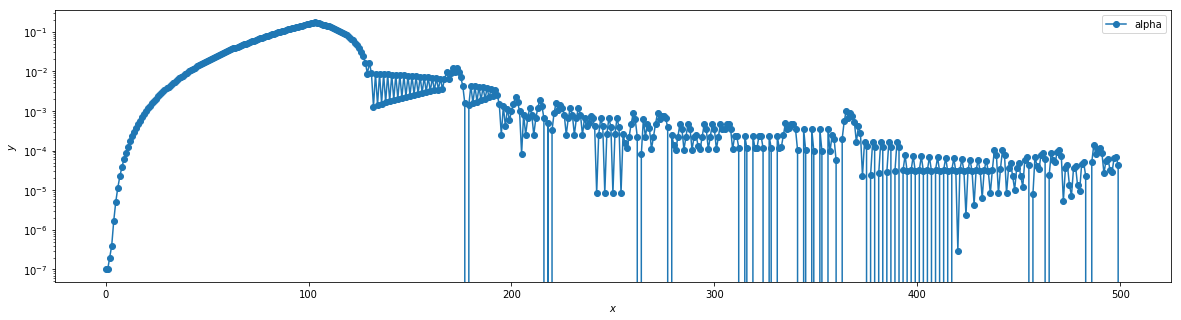

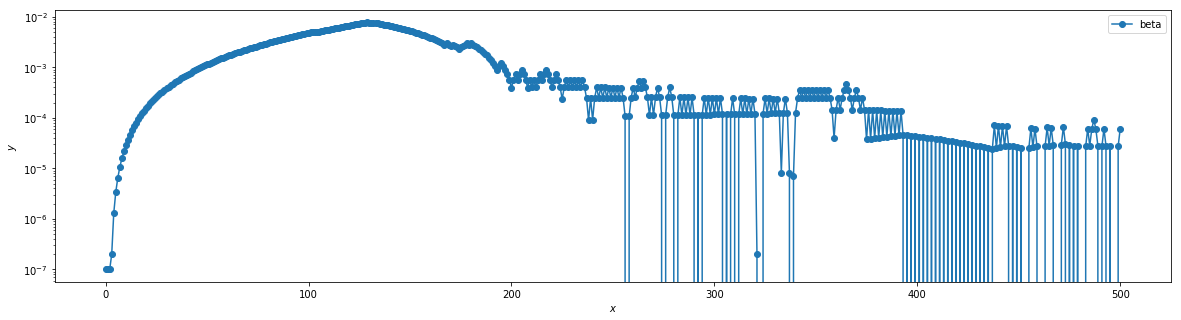

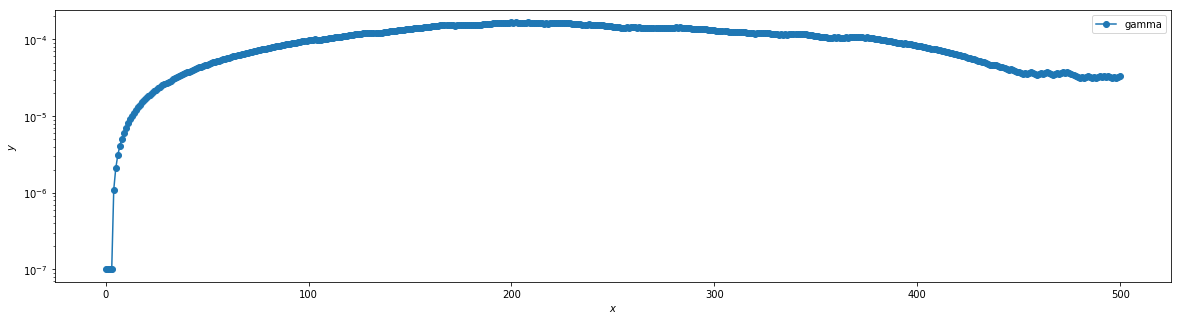

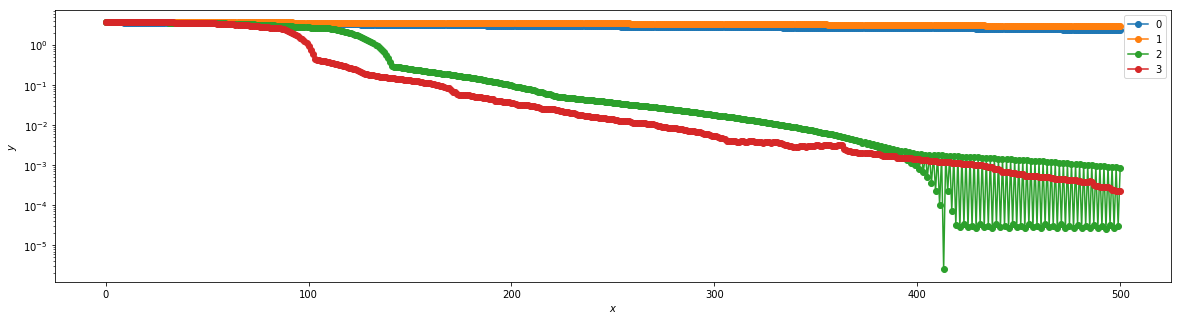

In [30]:
# drawAlphaPath(gd_alphaPath)
# drawAlphaPath(gdn_alphaPath)
# drawAlphaPath(hgd_alphaPath)
# drawAlphaPath(hgdn_alphaPath)
drawPath(hhhgdn_alphaPath, label="alpha")
drawPath(hhhgdn_betaPath, label="beta")
drawPath(hhhgdn_gammaPath, label="gamma")

# drawDistanceToPoint(hgdn_path, np.array([3, 0.5]))
drawDistanceToPoint([gdn_path, hgdn_path, hhgdn_path, hhhgdn_path], np.array([3, 0.5]))

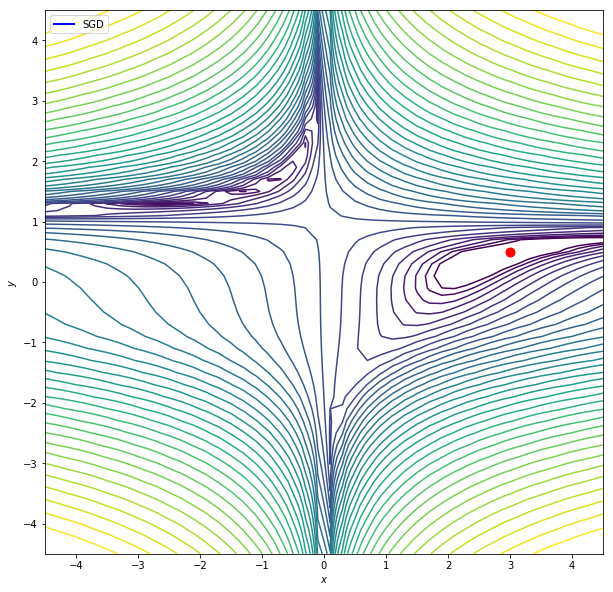

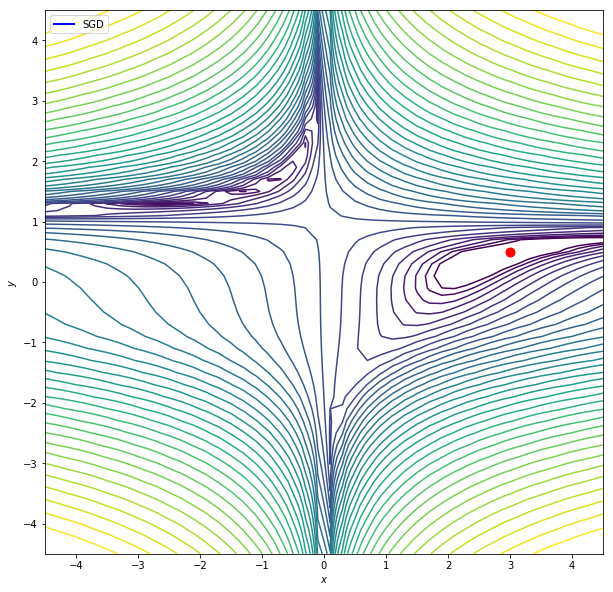

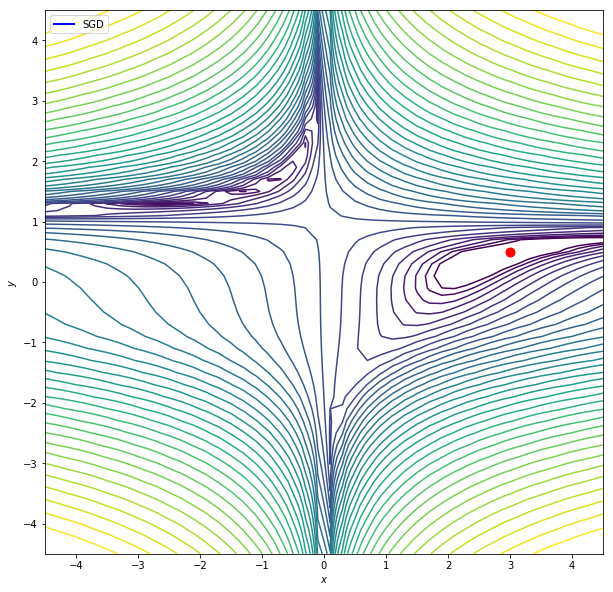

In [31]:
# gd_anim = makeAnimation(gd_path);
# gdn_anim = makeAnimation(gdn_path);
# hgd_anim = makeAnimation(hgd_path);
hgdn_anim = makeAnimation(hgdn_path);
hhgdn_anim = makeAnimation(hhgdn_path);
hhhgdn_anim = makeAnimation(hhhgdn_path);

In [32]:
HTML(hhhgdn_anim.to_html5_video())